<a href="https://colab.research.google.com/github/bhusserl-davis/ECS171-Group1-Project/blob/main/project_word2Vec_undersampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
# Download Needed Packages
import sys
!{sys.executable} -m pip install -q pandas
!{sys.executable} -m pip install -q nltk
!{sys.executable} -m pip install -q sklearn
!{sys.executable} -m pip install -q wordcloud==1.8.1
!{sys.executable} -m pip install -q gensim==3.8.3
!{sys.executable} -m pip install -q keras
!{sys.executable} -m pip install -q numpy
!{sys.executable} -m pip install -q matplotlib

     |████████████████████████████████| 371 kB 14.6 MB/s 
     |████████████████████████████████| 24.2 MB 1.3 MB/s 


In [2]:
# Import needed libraries and download needed data
import string
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

## Data Exploration

In [3]:
# Import Data
df = pd.read_csv("./fake_job_postings.csv")
print(f'{df.shape[0]} observations, {df.shape[1]} features')
display(df.head(5))

17880 observations, 18 features


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
# Print count of NaNs and type of each column
print("Column\t\t    NaNs   Type")
for column in df.columns:
    print(f'{column.ljust(20)}{str(df[column].isna().sum()).ljust(7)}{df[column].dtype}')

Column		    NaNs   Type
job_id              0      int64
title               0      object
location            346    object
department          11547  object
salary_range        15012  object
company_profile     3308   object
description         1      object
requirements        2695   object
benefits            7210   object
telecommuting       0      int64
has_company_logo    0      int64
has_questions       0      int64
employment_type     3471   object
required_experience 7050   object
required_education  8105   object
industry            4903   object
function            6455   object
fraudulent          0      int64


### replacesing NAN Value

In [5]:
#Replacing NAN Values
new_df = df.copy()
NAN_Cols=[
    "location","department","salary_range",
    "company_profile","description","requirements",
    "benefits","employment_type","required_experience",
    "required_experience","required_education","industry","function"
]
print("Column\t\t       NaNs")
for i in NAN_Cols:
    new_df[i].fillna("",inplace=True)
print(new_df.isnull().sum())

Column		       NaNs
job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64


In [6]:
# Get numeric columns unique values
numeric_atts = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
for column in numeric_atts:
    print(f'{column}: {new_df[column].unique()}')

job_id: [    1     2     3 ... 17878 17879 17880]
telecommuting: [0 1]
has_company_logo: [1 0]
has_questions: [0 1]
fraudulent: [0 1]


In [7]:
new_df[:5]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


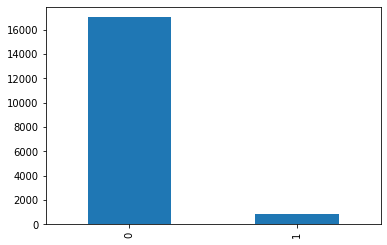

In [8]:
new_df['fraudulent'].value_counts().plot.bar()

### remove NAN Value

In [9]:
new_df = df.copy()

In [10]:
new_df=df.dropna()

In [11]:
print(f'before drop {df.shape[0]},after drop {new_df.shape[0]} ')

before drop 17880,after drop 774 


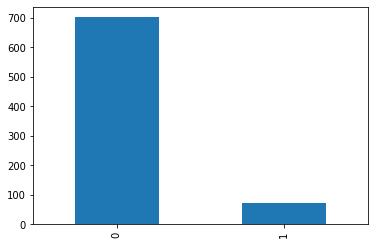

In [12]:
new_df['fraudulent'].value_counts().plot.bar()

In [13]:
new_df[:10]

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
15,16,VP of Sales - Vault Dragon,"SG, 01, Singapore",Sales,120000-150000,Jungle Ventures is the leading Singapore based...,About Vault Dragon Vault Dragon is Dropbox for...,Key Superpowers3-5 years of high-pressure sale...,"Basic: SGD 120,000Equity negotiable for a rock...",0,1,1,Full-time,Executive,Bachelor's Degree,Facilities Services,Sales,0
23,24,"Vice President, Sales and Sponsorship (Busines...","US, CA, Carlsbad",Businessfriend.com,100000-120000,"WDM Group is an innovative, forward thinking d...",#URL_eda2500ddcedb60957fcd7f5b164e092966f8c4e8...,"Job Requirements:A reputation as a ""go-getter""...",Businessfriend will offer a competitive six fi...,0,1,0,Full-time,Executive,Unspecified,Internet,Sales,0
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
102,103,Marketing Administrator,"GB, WAR, Coventry",Marketplace,15000-18000,Renewable Energy and Environmental Protection ...,The job is to support the growth of the #URL_9...,"Computer literateAble to work with HTML, altho...",For a suitably motivated and success orientate...,1,1,0,Full-time,Entry level,Bachelor's Degree,Internet,Marketing,0
134,135,Senior Business Development Manager,"GB, , Manchester",Sales and Business Development,70000-90000,MarketInvoice is one of the most high-profile ...,BACKGROUNDA senior sales and account managemen...,5-10 years sales experience in B2B solution sa...,Based in our Manchester officeCompetitive basi...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Financial Services,Sales,0
153,154,Senior Project Manager,"GB, , London",Production,28000-45000,"Neverbland is a team of designers, developers ...",Some of us are born with the ability to multi ...,2-3 years agency experience in a Producer/Proj...,"Work in a dynamic, creative environment.Learn ...",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Production,0
160,161,Field Services Supervisor,"US, WI, Western Wisconsin",Field Operations,44000-57000,"Dairy, food and beverage processors work withi...","W.M. Sprinkman designs, builds and installs st...",5-7 years of experience in fabrication and/or ...,We provide a solid benefits package with healt...,0,0,0,Full-time,Associate,High School or equivalent,Mechanical or Industrial Engineering,Manufacturing,0
179,180,Internal Recruiter,"GB, LND, London",Playfair Capital,20000-40000,Playfair Capital is an early stage technology ...,You will be responsible for hiring across a po...,Previous recruitment experience in fast growth...,Work will an awesome group of companies and be...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Human Resources,0
197,198,Software developer,"IN, MP, Indore",Software development,360000-600000,"Being into the IT domain for over 4 years, Wal...","Is coding just a task for you, or something to...",Min. 1 year in Web Development,In-house product development with a chance to ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0


## Preprocessing

### covert string to word token

In [14]:
# Convert Everything to lowercase
new_df = new_df.applymap(lambda s: s.lower() if type(s) == str else s)
display(new_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
6,7,head of content (m/f),"de, be, berlin",androidpit,20000-28000,"founded in 2009, the fonpit ag rose with its i...",your responsibilities: manage the english-spea...,your know-how: ...,your benefits: being part of a fast-growing co...,0,1,1,full-time,mid-senior level,master's degree,online media,management,0
15,16,vp of sales - vault dragon,"sg, 01, singapore",sales,120000-150000,jungle ventures is the leading singapore based...,about vault dragon vault dragon is dropbox for...,key superpowers3-5 years of high-pressure sale...,"basic: sgd 120,000equity negotiable for a rock...",0,1,1,full-time,executive,bachelor's degree,facilities services,sales,0
23,24,"vice president, sales and sponsorship (busines...","us, ca, carlsbad",businessfriend.com,100000-120000,"wdm group is an innovative, forward thinking d...",#url_eda2500ddcedb60957fcd7f5b164e092966f8c4e8...,"job requirements:a reputation as a ""go-getter""...",businessfriend will offer a competitive six fi...,0,1,0,full-time,executive,unspecified,internet,sales,0
98,99,ic&e technician,"us, , stocton, ca",oil & energy,95000-115000,...,"ic&amp;e technician | bakersfield, ca mt. poso...","qualificationsknowledge, skills &amp; abilitie...",benefitswhat is offered:competitive compensati...,0,1,1,full-time,mid-senior level,high school or equivalent,oil & energy,other,1
102,103,marketing administrator,"gb, war, coventry",marketplace,15000-18000,renewable energy and environmental protection ...,the job is to support the growth of the #url_9...,"computer literateable to work with html, altho...",for a suitably motivated and success orientate...,1,1,0,full-time,entry level,bachelor's degree,internet,marketing,0


In [15]:
# Remove Punctuation
punc_list = list(string.punctuation)
def remove_punctuation(text, punct_list):
    for punc in punct_list:
        if punc in text:
            text = text.replace(punc, ' ')
    return text

new_df = new_df.applymap(lambda s: remove_punctuation(s, punc_list) if type(s) == str else s)
display(new_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
6,7,head of content m f,de be berlin,androidpit,20000 28000,founded in 2009 the fonpit ag rose with its i...,your responsibilities manage the english spea...,your know how ...,your benefits being part of a fast growing co...,0,1,1,full time,mid senior level,master s degree,online media,management,0
15,16,vp of sales vault dragon,sg 01 singapore,sales,120000 150000,jungle ventures is the leading singapore based...,about vault dragon vault dragon is dropbox for...,key superpowers3 5 years of high pressure sale...,basic sgd 120 000equity negotiable for a rock...,0,1,1,full time,executive,bachelor s degree,facilities services,sales,0
23,24,vice president sales and sponsorship busines...,us ca carlsbad,businessfriend com,100000 120000,wdm group is an innovative forward thinking d...,url eda2500ddcedb60957fcd7f5b164e092966f8c4e8...,job requirements a reputation as a go getter ...,businessfriend will offer a competitive six fi...,0,1,0,full time,executive,unspecified,internet,sales,0
98,99,ic e technician,us stocton ca,oil energy,95000 115000,...,ic amp e technician bakersfield ca mt poso...,qualificationsknowledge skills amp abilitie...,benefitswhat is offered competitive compensati...,0,1,1,full time,mid senior level,high school or equivalent,oil energy,other,1
102,103,marketing administrator,gb war coventry,marketplace,15000 18000,renewable energy and environmental protection ...,the job is to support the growth of the url 9...,computer literateable to work with html altho...,for a suitably motivated and success orientate...,1,1,0,full time,entry level,bachelor s degree,internet,marketing,0


In [16]:
# Tokenize each text column
token_df = new_df.copy()
for column in new_df.columns:
    token_df[column] = new_df[column].apply(lambda s: word_tokenize(s) if type(s) == str else s)
display(token_df.head(5))

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
6,7,"[head, of, content, m, f]","[de, be, berlin]",[androidpit],"[20000, 28000]","[founded, in, 2009, the, fonpit, ag, rose, wit...","[your, responsibilities, manage, the, english,...","[your, know, how, university, or, college, deg...","[your, benefits, being, part, of, a, fast, gro...",0,1,1,"[full, time]","[mid, senior, level]","[master, s, degree]","[online, media]",[management],0
15,16,"[vp, of, sales, vault, dragon]","[sg, 01, singapore]",[sales],"[120000, 150000]","[jungle, ventures, is, the, leading, singapore...","[about, vault, dragon, vault, dragon, is, drop...","[key, superpowers3, 5, years, of, high, pressu...","[basic, sgd, 120, 000equity, negotiable, for, ...",0,1,1,"[full, time]",[executive],"[bachelor, s, degree]","[facilities, services]",[sales],0
23,24,"[vice, president, sales, and, sponsorship, bus...","[us, ca, carlsbad]","[businessfriend, com]","[100000, 120000]","[wdm, group, is, an, innovative, forward, thin...","[url, eda2500ddcedb60957fcd7f5b164e092966f8c4e...","[job, requirements, a, reputation, as, a, go, ...","[businessfriend, will, offer, a, competitive, ...",0,1,0,"[full, time]",[executive],[unspecified],[internet],[sales],0
98,99,"[ic, e, technician]","[us, stocton, ca]","[oil, energy]","[95000, 115000]","[staffing, amp, recruiting, done, right, for, ...","[ic, amp, e, technician, bakersfield, ca, mt, ...","[qualificationsknowledge, skills, amp, abiliti...","[benefitswhat, is, offered, competitive, compe...",0,1,1,"[full, time]","[mid, senior, level]","[high, school, or, equivalent]","[oil, energy]",[other],1
102,103,"[marketing, administrator]","[gb, war, coventry]",[marketplace],"[15000, 18000]","[renewable, energy, and, environmental, protec...","[the, job, is, to, support, the, growth, of, t...","[computer, literateable, to, work, with, html,...","[for, a, suitably, motivated, and, success, or...",1,1,0,"[full, time]","[entry, level]","[bachelor, s, degree]",[internet],[marketing],0


### tokenizer 

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_df['description'])

X = tokenizer.texts_to_sequences(token_df['description'])

In [19]:
X[0][:10]

[30, 110, 131, 3, 1864, 1865, 1282, 18, 1, 138]

In [20]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break    

and -> 1
to -> 2
the -> 3
of -> 4
a -> 5
in -> 6
for -> 7
with -> 8
our -> 9
you -> 10


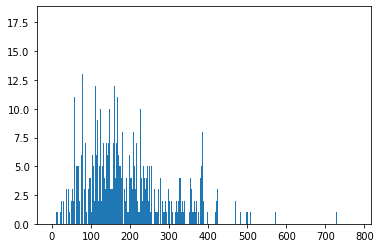

In [21]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [22]:
import numpy as np
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])


771

In [23]:
#Lets keep all descriptions to 700, add padding to descriptions with less than 700 words and truncating long ones
maxlen = 700 

#Making all descriptions of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [24]:
#all descriptions has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [25]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [26]:
y = new_df['fraudulent']

In [27]:
print(len(X))
print(len(y))

774
774


### oversample

In [28]:
from imblearn.over_sampling import RandomOverSampler

In [29]:
oversample = RandomOverSampler(sampling_strategy='minority')

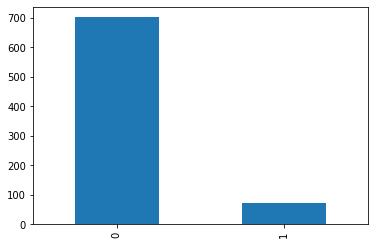

In [30]:
y.value_counts().plot.bar()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

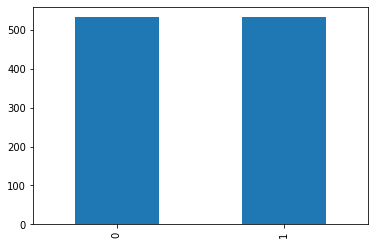

In [34]:
y_train.value_counts().plot.bar()

## Model Training

### model with no embedding layer

In [35]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
#LSTM 
model.add(LSTM(units=128,input_shape=(700, 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
24/24 [==============================] - 10s 62ms/step - loss: 0.6342 - acc: 0.6613 - val_loss: 1.3234 - val_acc: 0.0219
Epoch 2/6
24/24 [==============================] - 1s 41ms/step - loss: 0.5772 - acc: 0.7245 - val_loss: 1.2475 - val_acc: 0.0219
Epoch 3/6
24/24 [==============================] - 1s 40ms/step - loss: 0.5489 - acc: 0.7245 - val_loss: 1.1213 - val_acc: 0.0219
Epoch 4/6
24/24 [==============================] - 1s 47ms/step - loss: 0.4844 - acc: 0.7298 - val_loss: 0.7381 - val_acc: 0.4969
Epoch 5/6
24/24 [==============================] - 1s 40ms/step - loss: 0.4213 - acc: 0.7930 - val_loss: 0.9058 - val_acc: 0.4688
Epoch 6/6
24/24 [==============================] - 1s 40ms/step - loss: 0.3786 - acc: 0.8118 - val_loss: 0.7218 - val_acc: 0.7156


In [38]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

7/7 [==============================] - 0s 14ms/step


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       170
           1       0.46      0.71      0.56        24

    accuracy                           0.86       194
   macro avg       0.71      0.80      0.74       194
weighted avg       0.89      0.86      0.87       194



In [67]:
model.fit(X_train, y_train, validation_split=0.3, epochs=60)

Epoch 1/60
24/24 [==============================] - 1s 48ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 2/60
24/24 [==============================] - 1s 45ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 3/60
24/24 [==============================] - 1s 45ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 4/60
24/24 [==============================] - 1s 43ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 5/60
24/24 [==============================] - 1s 43ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 6/60
24/24 [==============================] - 1s 44ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 7/60
24/24 [==============================] - 1s 45ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 8/60
24/24 [==============================] - 1s 44ms/step - loss: 0.0014 - a

In [65]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

7/7 [==============================] - 0s 20ms/step


In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       170
           1       0.70      0.79      0.75        24

    accuracy                           0.93       194
   macro avg       0.84      0.87      0.85       194
weighted avg       0.94      0.93      0.93       194



### model with word2Vec embedding layer

In [43]:
EMBEDDING_DIM = 100

#### word2vec

In [44]:
import gensim

In [45]:
sentence = token_df['description']

In [46]:
print(type(sentence))
print(sentence.shape)
print(sentence)

<class 'pandas.core.series.Series'>
(774,)
6        [your, responsibilities, manage, the, english,...
15       [about, vault, dragon, vault, dragon, is, drop...
23       [url, eda2500ddcedb60957fcd7f5b164e092966f8c4e...
98       [ic, amp, e, technician, bakersfield, ca, mt, ...
102      [the, job, is, to, support, the, growth, of, t...
                               ...                        
17734    [we, are, seeking, a, candidate, whose, core, ...
17759    [we, are, seeking, a, candidate, whose, core, ...
17813    [we, are, seeking, a, candidate, whose, core, ...
17849    [balanced, labs, exists, to, improve, the, liv...
17865    [avenuestory, is, looking, for, a, curious, am...
Name: description, Length: 774, dtype: object


In [47]:
'reproducing' in sentence[6]

False

In [48]:
# initialize a model
w2v_model = gensim.models.Word2Vec(sentence, size=100, min_count=1)

In [49]:
def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

In [50]:
most_similar(w2v_model,['our','title','client','company'])

,our,cos,title,cos,client,cos,company,cos
0,success,0.998160,summary,0.999644,product,0.999024,values,0.997908
1,rapidly,0.997701,out,0.999626,amp,0.998494,progress,0.997015
2,professional,0.997471,description,0.999602,social,0.998428,five,0.994460
3,technology,0.997025,those,0.999596,hardware,0.998317,sme,0.993263
4,developers,0.996898,hours,0.999541,media,0.998295,world,0.993018
5,positions,0.996592,dedicated,0.999512,including,0.998063,go,0.992845
6,awesome,0.996589,created,0.999484,design,0.997997,version,0.992690
7,driven,0.996582,office,0.999473,marketing,0.997703,blippar,0.991669
8,employees,0.996551,set,0.999461,through,0.997654,ngo,0.990675
9,revolution,0.996543,focus,0.999423,discover,0.997590,biggest,0.990452


#### create embedding_vectors

In [51]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [52]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [53]:
w2v_model.wv['and']

array([ 4.56880242e-01,  2.04346150e-01, -3.55284512e-01, -3.70565861e-01,
       -1.42675948e+00,  2.99992472e-01,  2.57125705e-01,  9.17536139e-01,
       -6.21291995e-01,  1.53362572e-01, -1.45871326e-01, -6.49181306e-01,
       -9.77707282e-02, -5.67785144e-01, -7.16879129e-01, -6.74359426e-02,
        8.90764967e-02,  1.82797992e+00, -1.97023213e+00, -1.24822712e+00,
       -5.72410405e-01, -2.20801741e-01, -6.36132538e-01,  6.26513362e-01,
       -7.63006151e-01,  6.30112961e-02, -7.71759525e-02,  1.07777745e-01,
       -1.49716198e-01, -7.04007030e-01,  1.68781137e+00, -2.18061790e-01,
       -3.67514968e-01,  4.49742854e-01,  5.41391730e-01, -8.52854177e-02,
        5.93395114e-01,  1.62854046e-01,  1.62861515e-02, -4.38025683e-01,
       -4.36772674e-01,  1.32931876e+00, -5.07462800e-01,  3.94048184e-01,
       -5.56362391e-01, -1.02190085e-01,  1.40455282e+00,  1.11105394e+00,
       -1.04443634e+00,  3.86399180e-01, -6.60520852e-01, -9.72135589e-02,
        1.59158081e-01, -

In [54]:
embedding_vectors[1][:100]

array([ 4.56880242e-01,  2.04346150e-01, -3.55284512e-01, -3.70565861e-01,
       -1.42675948e+00,  2.99992472e-01,  2.57125705e-01,  9.17536139e-01,
       -6.21291995e-01,  1.53362572e-01, -1.45871326e-01, -6.49181306e-01,
       -9.77707282e-02, -5.67785144e-01, -7.16879129e-01, -6.74359426e-02,
        8.90764967e-02,  1.82797992e+00, -1.97023213e+00, -1.24822712e+00,
       -5.72410405e-01, -2.20801741e-01, -6.36132538e-01,  6.26513362e-01,
       -7.63006151e-01,  6.30112961e-02, -7.71759525e-02,  1.07777745e-01,
       -1.49716198e-01, -7.04007030e-01,  1.68781137e+00, -2.18061790e-01,
       -3.67514968e-01,  4.49742854e-01,  5.41391730e-01, -8.52854177e-02,
        5.93395114e-01,  1.62854046e-01,  1.62861515e-02, -4.38025683e-01,
       -4.36772674e-01,  1.32931876e+00, -5.07462800e-01,  3.94048184e-01,
       -5.56362391e-01, -1.02190085e-01,  1.40455282e+00,  1.11105394e+00,
       -1.04443634e+00,  3.86399180e-01, -6.60520852e-01, -9.72135589e-02,
        1.59158081e-01, -

In [55]:
embedding_vectors[1].size

100

#### add embedding into model

In [56]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          926000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,043,377
Trainable params: 117,377
Non-trainable params: 926,000
_________________________________________________________________


In [58]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
24/24 [==============================] - 3s 66ms/step - loss: 0.6197 - acc: 0.6855 - val_loss: 1.2425 - val_acc: 0.0000e+00
Epoch 2/6
24/24 [==============================] - 1s 44ms/step - loss: 0.5803 - acc: 0.7151 - val_loss: 1.2400 - val_acc: 0.0000e+00
Epoch 3/6
24/24 [==============================] - 1s 45ms/step - loss: 0.5747 - acc: 0.7164 - val_loss: 0.9993 - val_acc: 0.0219
Epoch 4/6
24/24 [==============================] - 1s 43ms/step - loss: 0.5589 - acc: 0.7245 - val_loss: 1.2127 - val_acc: 0.0219
Epoch 5/6
24/24 [==============================] - 1s 44ms/step - loss: 0.5283 - acc: 0.7406 - val_loss: 1.2448 - val_acc: 0.2469
Epoch 6/6
24/24 [==============================] - 1s 55ms/step - loss: 0.5704 - acc: 0.7339 - val_loss: 1.5506 - val_acc: 0.0000e+00


In [59]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

7/7 [==============================] - 2s 37ms/step


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       170
           1       0.00      0.00      0.00        24

    accuracy                           0.88       194
   macro avg       0.44      0.50      0.47       194
weighted avg       0.77      0.88      0.82       194



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
model.fit(X_train, y_train, validation_split=0.3, epochs=60)

Epoch 1/60
24/24 [==============================] - 1s 47ms/step - loss: 2.2983e-04 - acc: 1.0000 - val_loss: 4.8408e-04 - val_acc: 1.0000
Epoch 2/60
24/24 [==============================] - 1s 44ms/step - loss: 2.2329e-04 - acc: 1.0000 - val_loss: 4.7263e-04 - val_acc: 1.0000
Epoch 3/60
24/24 [==============================] - 1s 51ms/step - loss: 2.1767e-04 - acc: 1.0000 - val_loss: 4.8154e-04 - val_acc: 1.0000
Epoch 4/60
24/24 [==============================] - 1s 51ms/step - loss: 2.1220e-04 - acc: 1.0000 - val_loss: 4.4433e-04 - val_acc: 1.0000
Epoch 5/60
24/24 [==============================] - 1s 44ms/step - loss: 2.0660e-04 - acc: 1.0000 - val_loss: 4.3990e-04 - val_acc: 1.0000
Epoch 6/60
24/24 [==============================] - 1s 44ms/step - loss: 2.0275e-04 - acc: 1.0000 - val_loss: 4.2005e-04 - val_acc: 1.0000
Epoch 7/60
24/24 [==============================] - 1s 44ms/step - loss: 1.9872e-04 - acc: 1.0000 - val_loss: 4.1169e-04 - val_acc: 1.0000
Epoch 8/60
24/24 [=========

In [69]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

7/7 [==============================] - 0s 20ms/step


In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       170
           1       0.76      0.67      0.71        24

    accuracy                           0.93       194
   macro avg       0.86      0.82      0.84       194
weighted avg       0.93      0.93      0.93       194

